In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from dotenv import load_dotenv
import plotly.express as px
import os

sns.set(style="whitegrid")
plt.rcParams.update({'figure.figsize': (10, 6)})

if not os.path.exists('./charts'):
    os.makedirs('./charts')

In [2]:
load_dotenv()
API_URL = os.getenv('API_URL')
DATE_BEGIN = os.getenv('DATE_BEGIN')
DATE_END = os.getenv('DATE_END')

In [3]:
visits_url = f"{API_URL}/visits?begin={DATE_BEGIN}&end={DATE_END}"
regs_url = f"{API_URL}/registrations?begin={DATE_BEGIN}&end={DATE_END}"
visits_df = pd.DataFrame(requests.get(visits_url).json())
regs_df = pd.DataFrame(requests.get(regs_url).json())

In [4]:
visits_df['date'] = pd.to_datetime(visits_df['datetime']).dt.date
regs_df["date"] = pd.to_datetime(regs_df["datetime"]).dt.date

In [5]:
visits_df = visits_df[~visits_df["user_agent"].str.contains("bot", case=False, na=False)]

visits_df = visits_df.sort_values("datetime").drop_duplicates("visit_id", keep="last")

In [6]:
visits_grouped = visits_df.groupby(["date", "platform"]).size().reset_index(name="visits")
regs_grouped = regs_df.groupby(["date", "platform"]).size().reset_index(name="registrations")

In [7]:
merged_df = pd.merge(
    visits_grouped, 
    regs_grouped, 
    on=["date", "platform"], 
    how="outer"
)
merged_df["visits"] = merged_df["visits"].fillna(0).astype(int)
merged_df["registrations"] = merged_df["registrations"].fillna(0).astype(int)
merged_df["conversion"] = merged_df.apply(
    lambda row: (row["registrations"] / row["visits"] * 100) if row["visits"] > 0 else 0, axis=1
)
merged_df = merged_df.sort_values("date")

In [8]:
conversion = merged_df.rename(columns={"date": "date_group"})[["date_group", "platform", "visits", "registrations", "conversion"]]
conversion.to_json("conversion.json", orient="columns")

In [9]:
ads_df = pd.read_csv("ads.csv")
ads_df["date"] = pd.to_datetime(ads_df["date"]).dt.date
ads_df["cost"] = pd.to_numeric(ads_df["cost"], errors="coerce").fillna(0)
ads_grouped = ads_df.groupby(["date", "utm_campaign"]).agg(cost=("cost", "sum")).reset_index()

In [10]:
ads_merged = pd.merge(merged_df, ads_grouped, on="date", how="left").fillna(0)
ads_merged.to_json("ads.json", orient="columns")

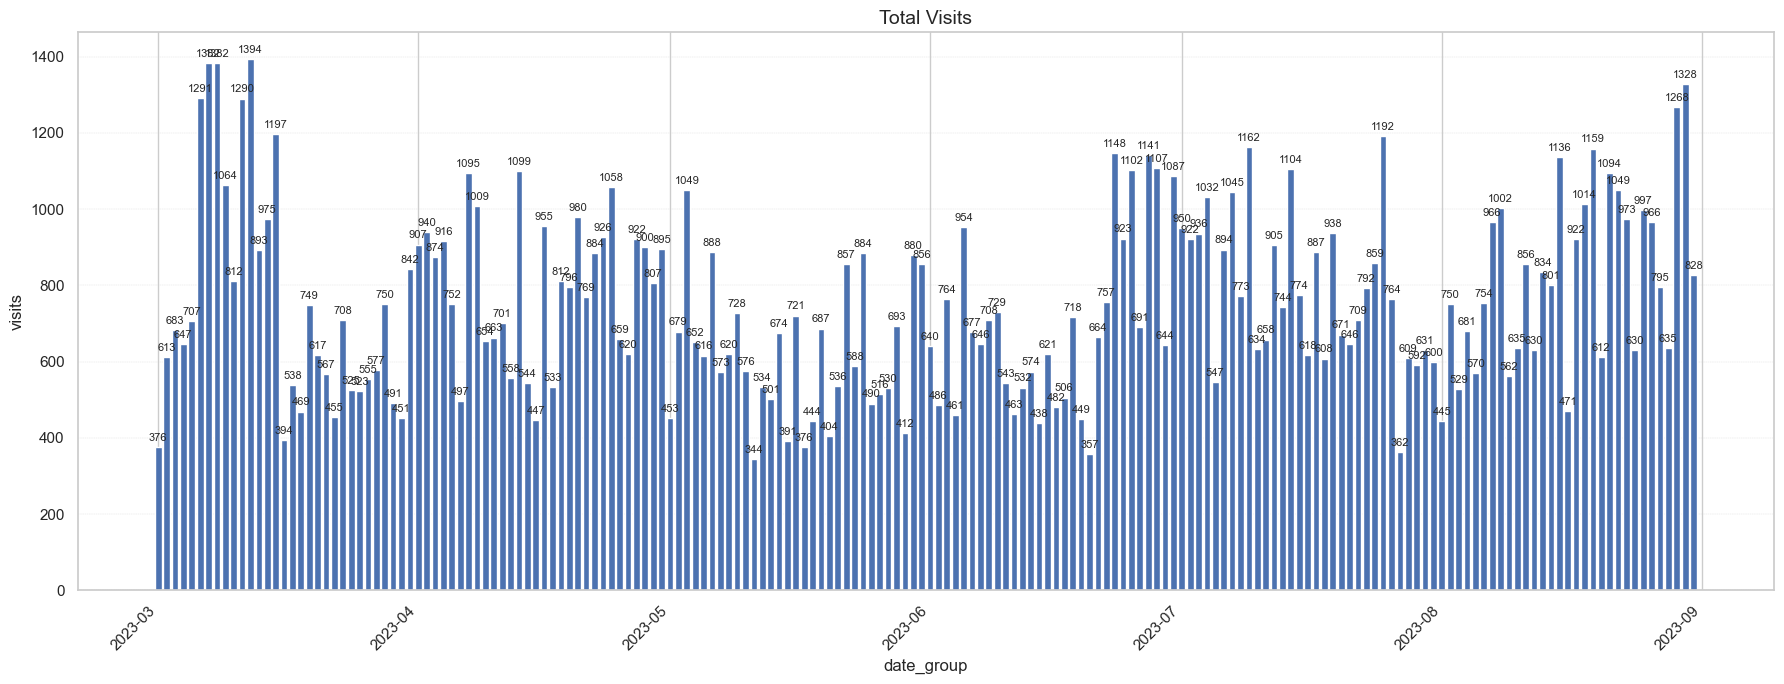

In [13]:
daily_visits = (merged_df
                .groupby('date', as_index=False)['visits']
                .sum()
                .sort_values('date'))
fig, ax = plt.subplots(figsize=(18, 7))
bars = ax.bar(daily_visits['date'],
              daily_visits['visits'])

for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{int(height)}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords='offset points',
                ha='center', va='bottom',
                fontsize=8)

ax.set_title('Total Visits', fontsize=14)
ax.set_xlabel('date_group')
ax.set_ylabel('visits')
plt.xticks(rotation=45, ha='right')
ax.grid(axis='y', linestyle='--', linewidth=0.3, alpha=0.7)

plt.tight_layout()
plt.savefig('./charts/total_visits.png')

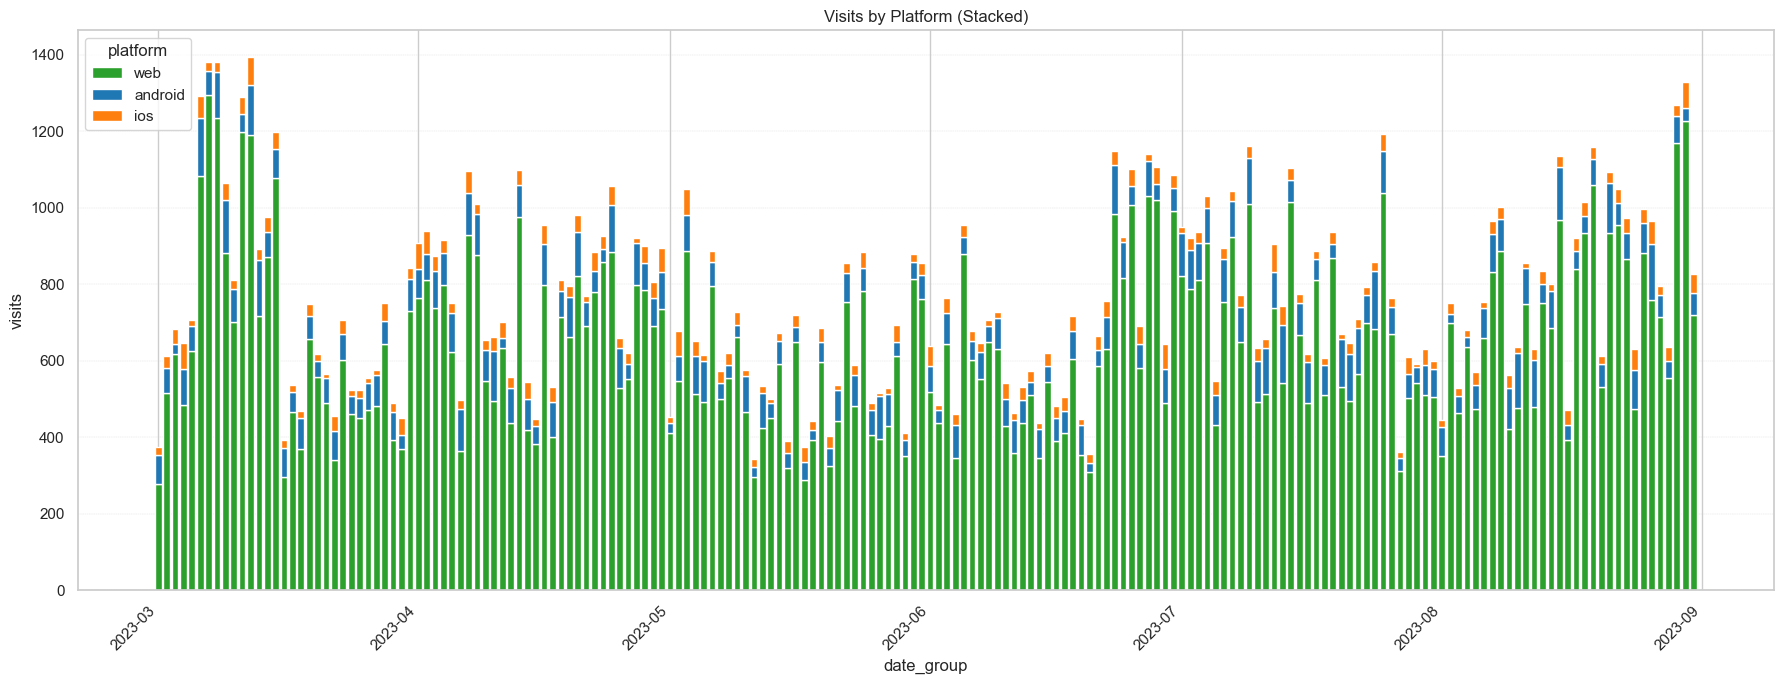

In [14]:
conversion['date_group'] = pd.to_datetime(conversion['date_group'])

pivot = (conversion.pivot_table(index='date_group',
                      columns='platform',
                      values='visits',
                      aggfunc='sum')
         .fillna(0)
         .sort_index())
pivot = pivot.reindex(columns=['web', 'android', 'ios'])

fig, ax = plt.subplots(figsize=(18, 7))

bottom = np.zeros(len(pivot))
colors = {'web':   '#2ca02c',
          'android': '#1f77b4',
          'ios':    '#ff7f0e'}

for platform in pivot.columns:
    ax.bar(pivot.index,
           pivot[platform],
           bottom=bottom,
           label=platform,
           color=colors.get(platform))
    bottom += pivot[platform].values

plt.xticks(rotation=45, ha='right')

ax.set_title('Visits by Platform (Stacked)')
ax.set_xlabel('date_group')
ax.set_ylabel('visits')
ax.legend(title='platform')
ax.grid(axis='y', linestyle='--', linewidth=0.3, alpha=0.7)
plt.savefig('./charts/Visits_by_platform.png')
plt.tight_layout()
plt.show()

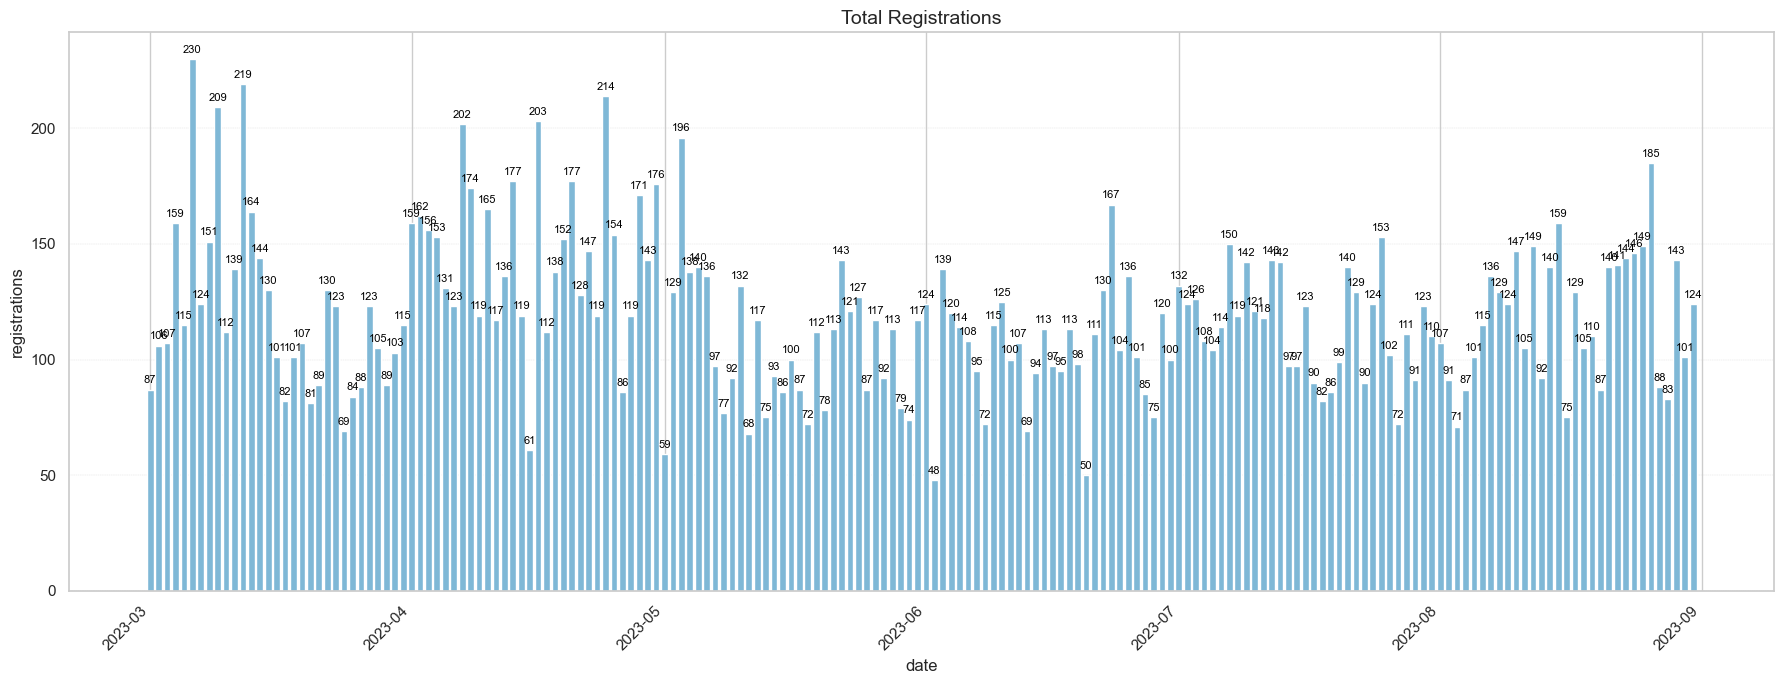

In [16]:
merged_df['date'] = pd.to_datetime(merged_df['date'])
daily_regs = (
    merged_df
    .groupby('date', as_index=False)['registrations']
    .sum()
    .sort_values('date')
)
fig, ax = plt.subplots(figsize=(18, 7))
bars = ax.bar(daily_regs['date'],
              daily_regs['registrations'],
              color='#7fb8d6')

for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{int(height)}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords='offset points',
                ha='center', va='bottom',
                fontsize=8, color='black')

ax.set_title('Total Registrations', fontsize=14)
ax.set_xlabel('date')
ax.set_ylabel('registrations')

plt.xticks(rotation=45, ha='right')
ax.grid(axis='y', linestyle='--', linewidth=0.3, alpha=0.7)
plt.savefig('./charts/total_registrations.png')
plt.tight_layout()
plt.show()

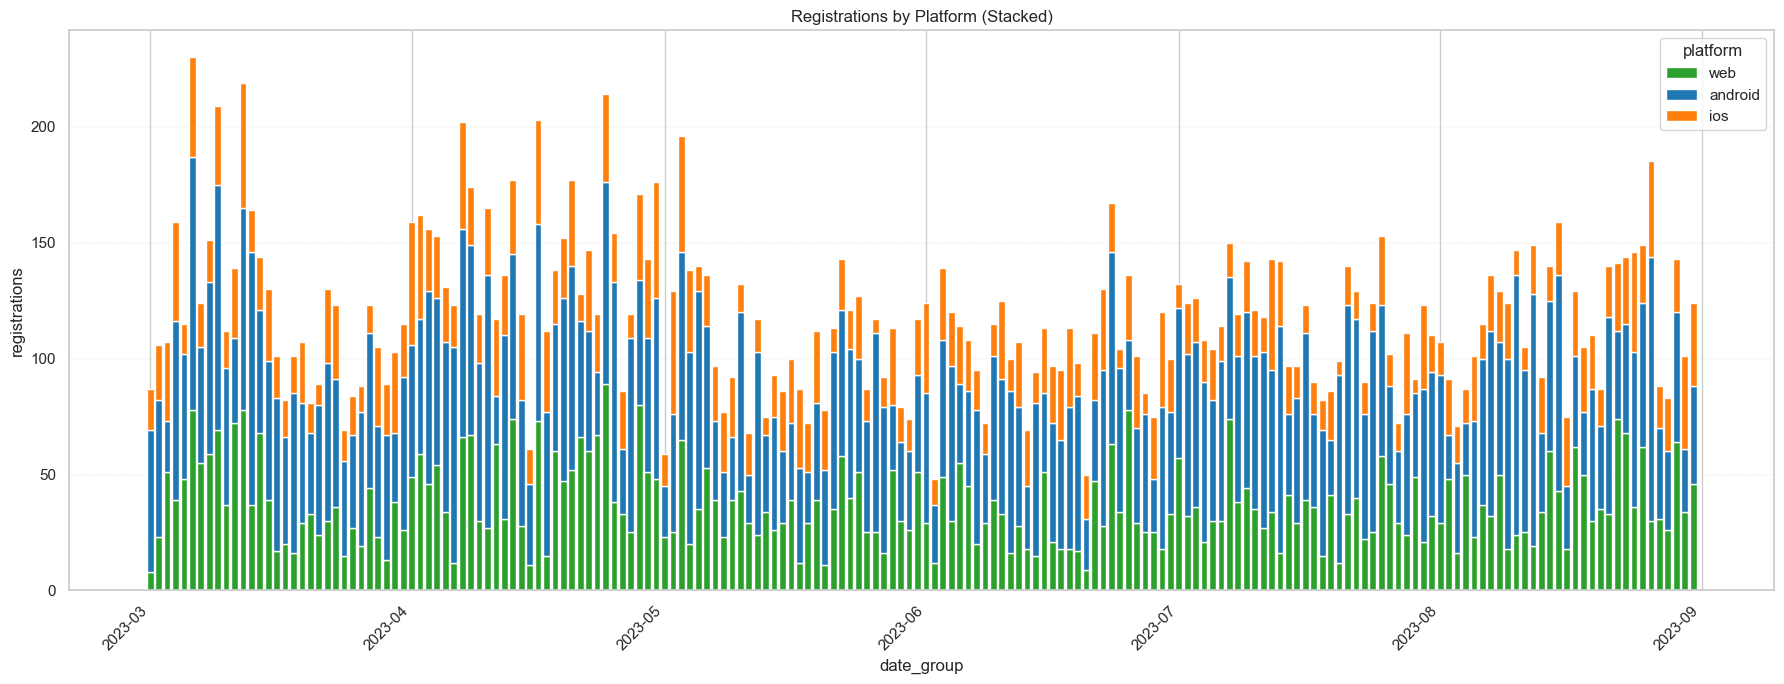

In [17]:
pivot_regs = (conversion.pivot_table(index='date_group',
                           columns='platform',
                           values='registrations',
                           aggfunc='sum')
              .fillna(0)
              .sort_index())

pivot_regs = pivot_regs.reindex(columns=['web', 'android', 'ios'])

fig, ax = plt.subplots(figsize=(18, 7))

bottom = np.zeros(len(pivot_regs))
palette = {'web':     '#2ca02c',
           'android': '#1f77b4',
           'ios':     '#ff7f0e'}

for platform in pivot_regs.columns:
    ax.bar(pivot_regs.index,
           pivot_regs[platform],
           bottom=bottom,
           label=platform,
           color=palette.get(platform))
    bottom += pivot_regs[platform].values

plt.xticks(rotation=45, ha='right')

ax.set_title('Registrations by Platform (Stacked)')
ax.set_xlabel('date_group')
ax.set_ylabel('registrations')
ax.legend(title='platform')
ax.grid(axis='y', linestyle='--', linewidth=0.3, alpha=0.7)
plt.savefig('./charts/regs_by_platform.png')
plt.tight_layout()
plt.show()

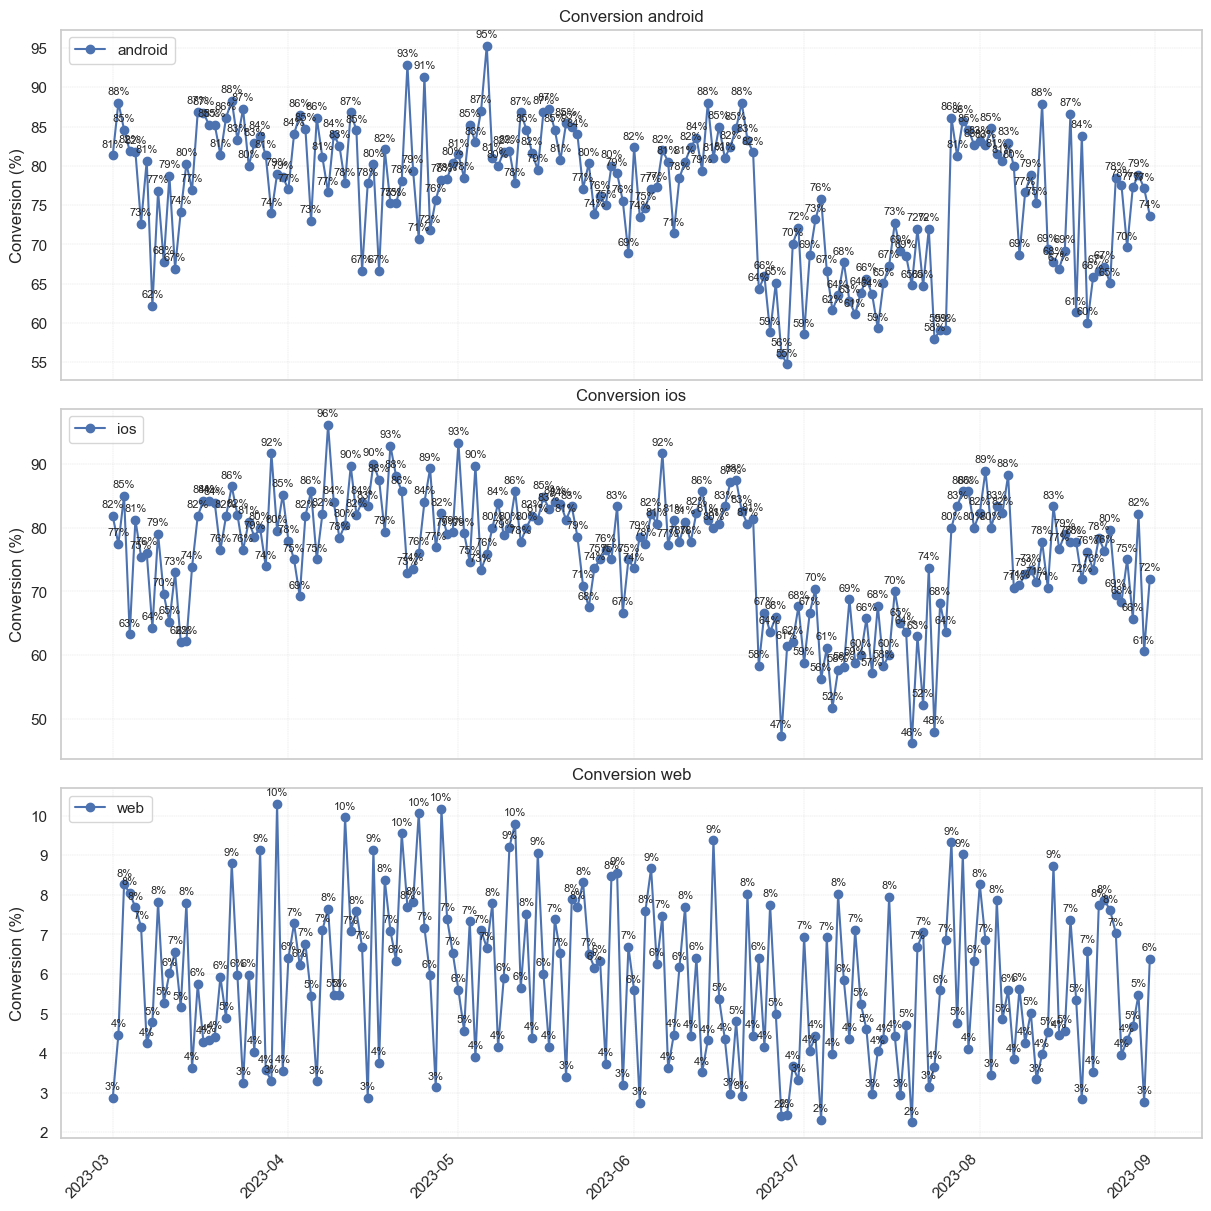

In [18]:
conv_daily = (conversion.groupby(['date_group', 'platform'], as_index=False)['conversion']
              .mean())
platform_order = ['android', 'ios', 'web']

fig, axes = plt.subplots(nrows=3,
                         ncols=1,
                         figsize=(12, 12),
                         sharex=True,
                         constrained_layout=True)

for ax, plat in zip(axes, platform_order):
    data = conv_daily[conv_daily['platform'] == plat].sort_values('date_group')

    ax.plot(data['date_group'],
            data['conversion'],
            marker='o',
            linestyle='-',
            label=plat)

    for x, y in zip(data['date_group'], data['conversion']):
        ax.annotate(f'{y:.0f}%', (x, y),
                    textcoords='offset points',
                    xytext=(0, 6),
                    ha='center',
                    fontsize=8)

    ax.set_title(f'Conversion {plat}')
    ax.set_ylabel('Conversion (%)')
    ax.grid(True, linestyle='--', linewidth=0.3, alpha=0.7)
    ax.legend(loc='upper left')

plt.setp(axes[-1].get_xticklabels(), rotation=45, ha='right')
plt.savefig('./charts/conversions_on_platform.png')
plt.show()

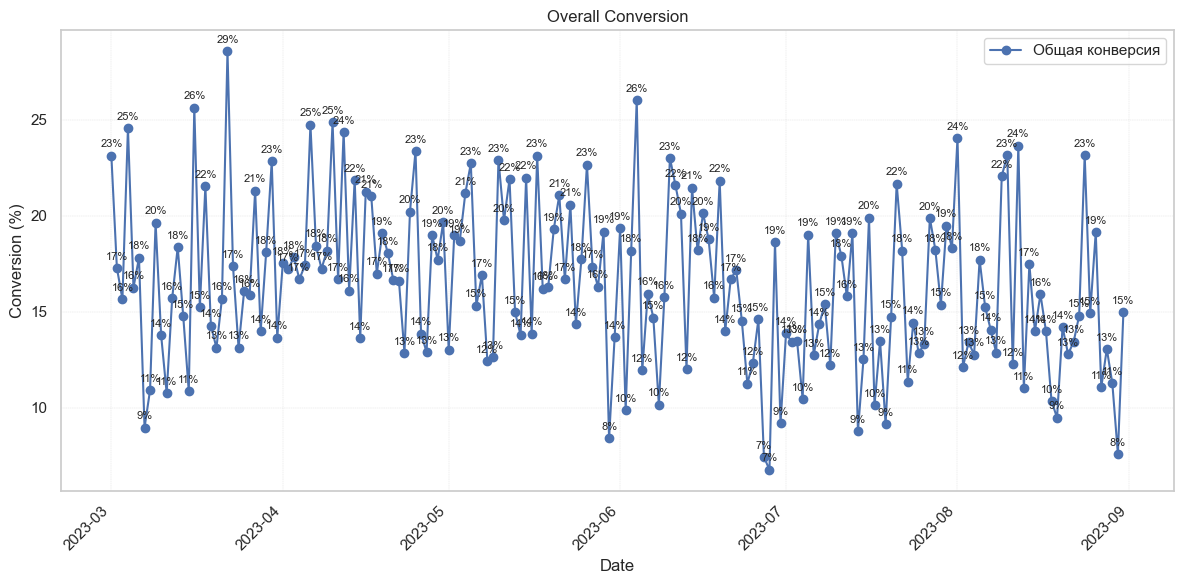

In [22]:
merged_df['date'] = pd.to_datetime(merged_df['date'])
daily_totals = (merged_df
                .groupby('date', as_index=False)
                .agg({'visits': 'sum', 'registrations': 'sum'})
                .sort_values('date'))
daily_totals['conversion'] = (daily_totals['registrations']
                              / daily_totals['visits'] * 100)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(daily_totals['date'],
        daily_totals['conversion'],
        marker='o',
        linestyle='-',
        label='Общая конверсия')

for x, y in zip(daily_totals['date'], daily_totals['conversion']):
    ax.annotate(f'{y:.0f}%', (x, y),
                textcoords='offset points',
                xytext=(0, 6),
                ha='center',
                fontsize=8)

ax.set_title('Overall Conversion')
ax.set_xlabel('Date')
ax.set_ylabel('Conversion (%)')
ax.legend()

plt.xticks(rotation=45, ha='right')

ax.grid(True, linestyle='--', linewidth=0.3, alpha=0.7)
plt.tight_layout()
plt.savefig('./charts/overall_conversion.png')
plt.show()

In [25]:
ads_costs = ads_grouped.groupby("date")["cost"].sum().reset_index()
sns.lineplot(data=ads_costs, x="date", y="cost")
plt.title("Стоимость рекламы")
plt.xlabel("Дата")
plt.ylabel("Стоимость")
plt.tight_layout()
plt.savefig("charts/ads_costs.png")
plt.clf()
plt.show()

<Figure size 1000x600 with 0 Axes>

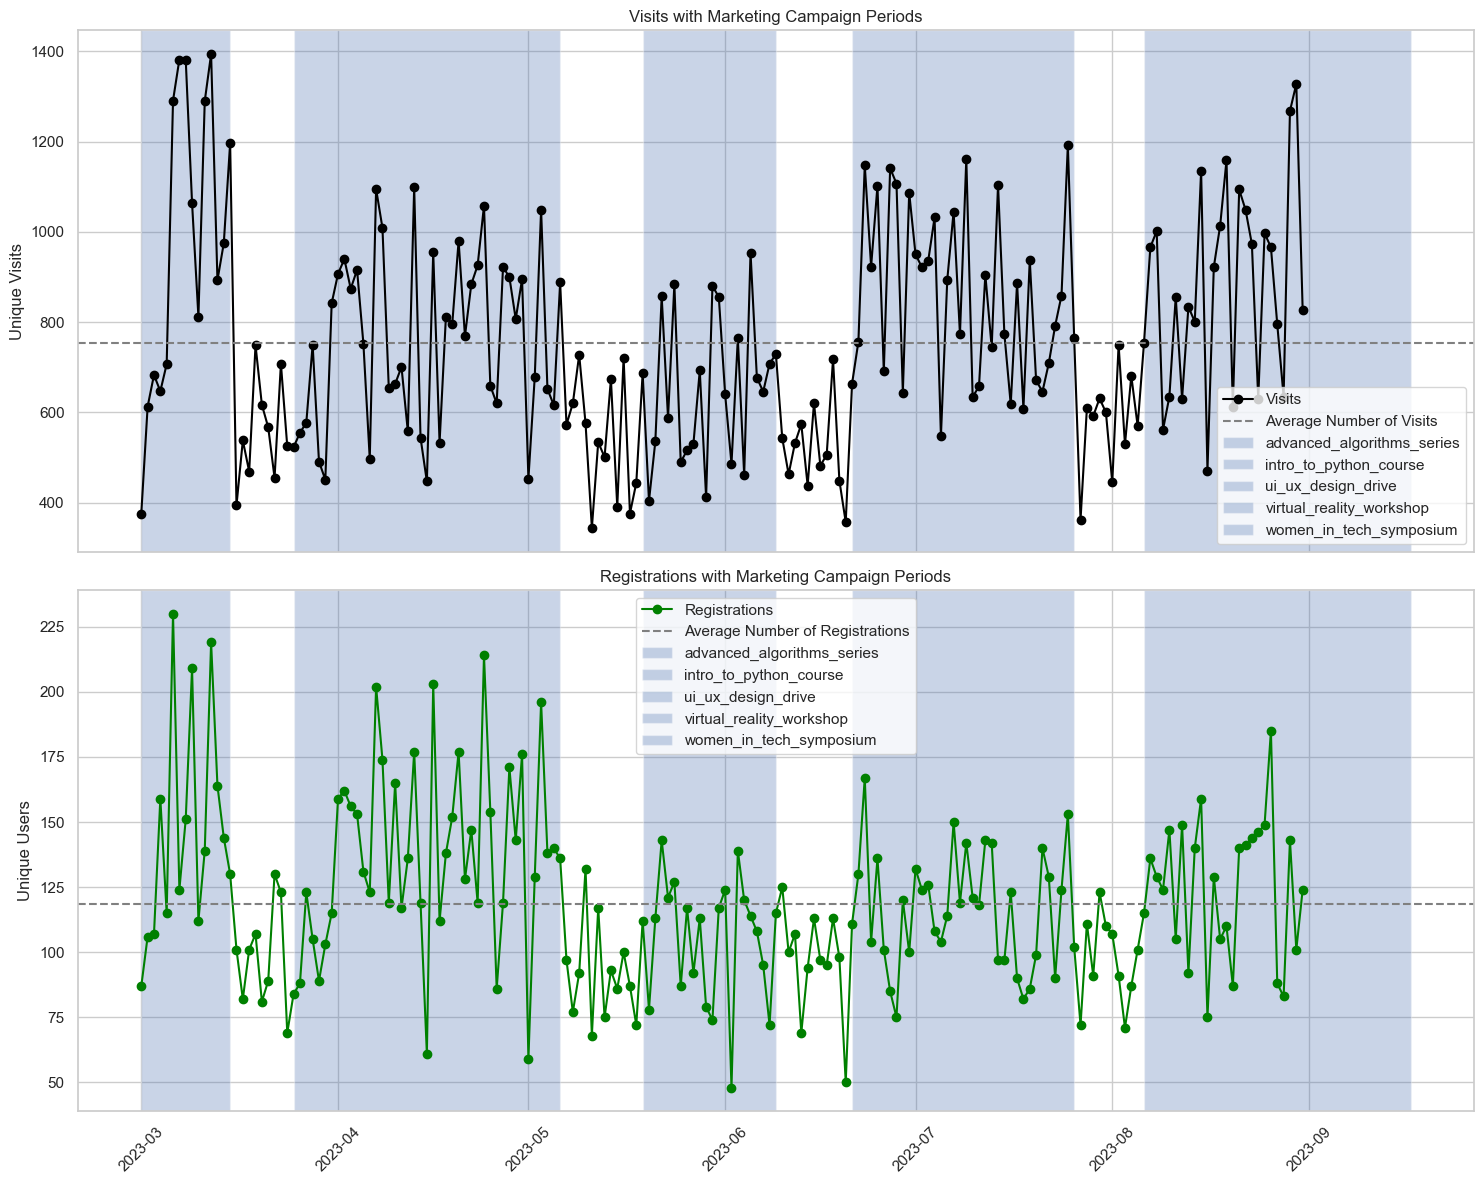

In [29]:
daily = merged_df.groupby('date').agg({
    'visits': 'sum',
    'registrations': 'sum'
}).reset_index()

campaigns = ads_df.groupby('utm_campaign').agg(
    start=('date', 'min'),
    end=('date', 'max')
).reset_index()

fig, ax = plt.subplots(2, 1, figsize=(15, 12), sharex=True)

# === ВИЗИТЫ ===
ax[0].plot(daily['date'], daily['visits'], '-o', color='black', label='Visits')
ax[0].axhline(daily['visits'].mean(), color='gray', linestyle='--', label='Average Number of Visits')

# Рекламные фоны
for _, row in campaigns.iterrows():
    ax[0].axvspan(row['start'], row['end'], alpha=0.3, label=row['utm_campaign'])

ax[0].set_ylabel('Unique Visits')
ax[0].legend()
ax[0].set_title('Visits with Marketing Campaign Periods')

# === РЕГИСТРАЦИИ ===
ax[1].plot(daily['date'], daily['registrations'], '-o', color='green', label='Registrations')
ax[1].axhline(daily['registrations'].mean(), color='gray', linestyle='--', label='Average Number of Registrations')

for _, row in campaigns.iterrows():
    ax[1].axvspan(row['start'], row['end'], alpha=0.3, label=row['utm_campaign'])

ax[1].set_ylabel('Unique Users')
ax[1].legend()
ax[1].set_title('Registrations with Marketing Campaign Periods')

plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig('./charts/visits_and_regs.png')
plt.show()